<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/15_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate 

# Module 3: Practical Deep Learning

# Convolutional Neural Network
**Text Book:** Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, Second Edition, Aurélien Géron

Source: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# The Problem of Using Fully Connected Neural Networks for Image Understanding

So far we have discussed fully connected newtworks and we used that even for images. Diagram below shows the idea:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/fcn_image.png" width="80%"></img>

But this approach has two main problems:

1. High number of inputs means huge number of parameters to learn and therefore requires huge number of training samples
2. Spatial relationship between image pixels is lost


## High Number of Weights

Imagine the input image size for an image classification (100 classes) is 200 x 200 pixels and 3 color channels (RGB). If we choose a very shallow fully connected network with only two hidden values with 4000 and 1000 Neurons. How many parameters the model will have?

Num of Parameters = $(200\times200\times3 + 1)\times4000 + 4001\times1000 + 1001\times100 = 484,105,100$

That's huge number of parameters to learn.

## Loss of Spatial Relationship

Consider the following two basic images. They represent two different images but the flatten vectors for both are the same:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/spatial_loss.png" width="80%"></img>

Human's brain understand the images by looking at their 2D representation not 1D representation. Therefore, we need a model that does the same. As usual, we get inspired by humen brain. 

# The Architecture of the Visual Cortex


A Nobel prize winning research has shown that:

- Many neurons in the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field (figure below)
- The receptive fields of different neurons may overlap, and together they tile the whole visual field.
- Some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations) 

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/local_receptive.png" width="80%"></img>

- They also noticed that some neurons have larger receptive fields, and they react to more com‐ plex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons (Figure below).
- This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/cortex_system.png" width="80%"></img>

In conclusion, the visual system has **convolution property** and **multi-layer** structure.

# Convolutional Neural Network (CNN)

The above studies of the visual cortex inspired the discovery of Convolutional Neural Networks. Some reaserachers introduced the famous LeNet-5 architecture, widely used to recognize handwritten check numbers. This architecture has some building blocks that you already know, such as fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: **convolutional layers** and pooling layers.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/lenet-5.png" width="90%"></img>

## Convolutional Layer

The most important building block of a CNN is the **convolutional layer** 
- Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in fully connected newtworks), but only to pixels in their receptive fields (Figure below). 
- In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. 
- This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on. 
- This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/convolutional_layers.png" width="70%"></img>

- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h – 1$, columns $j$ to $j + f_w – 1$, where $f_h$ and $f_w$ are the height and width of the receptive field (a.k.a. filter). 
- In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called zero padding.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/zero_padding.png" width="70%"></img>

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. The shift from one receptive field to the next is called the **stride**. 

In the following diagram, a $5 × 7$ input layer (plus zero padding) is connected to a $3 × 4$ layer, using $3 × 3$ receptive fields and a stride of $2$ (in this example the stride is the same in both directions, but it does not have to be so). A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i × s_h$ to $i × s_h + f_h – 1$, columns $j × s_w$ to $j × s_w + f_w – 1$, where $s_h$ and $s_w$ are the vertical and horizontal strides.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/stride.png" width="70%"></img>

The following animated gif shows the convolution process:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/2D_Convolution_Animation.gif" width="60%"></img>

## Filters

A neuron’s weights can be represented as a small image the size of the receptive field. For example, the following figure shows two possible sets of weights, called filters (or convolution kernels):

1. The first one is represented as a black square with a vertical white line in the middle (it is a 7 × 7 matrix full of 0s except for the central column, which is full of 1s); neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). 
2. The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

A layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. 

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/filters.png" width="80%"></img>

## Stacking Multiple Feature Maps

In reality a convolutional layer has multiple filters (you decide how many), and it outputs one feature map per filter, so it is more accurately represented in 3D.

It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term). However, neurons in different feature maps use different parameters.

In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

Moreover, input images are also composed of multiple sublayers: one per color channel. There are typically three: red, green, and blue (RGB). Grayscale images have just one channel, but some images may have much more—for example, satellite images that capture extra light frequencies (such as infrared).

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/stacked_filters.png" width="60%"></img>

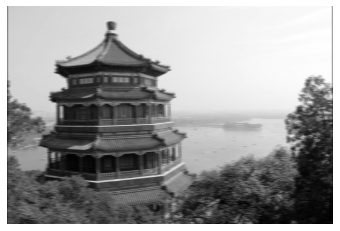

In [8]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") 
plt.show()

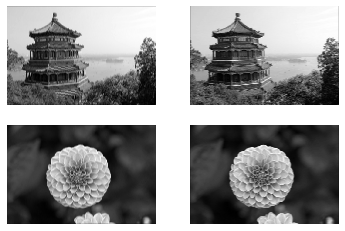

In [7]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [8]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


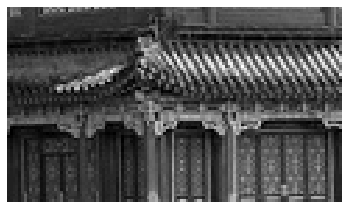

Saving figure china_vertical


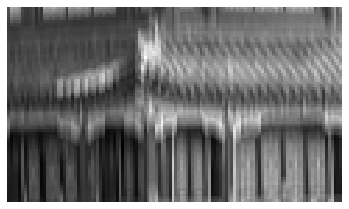

Saving figure china_horizontal


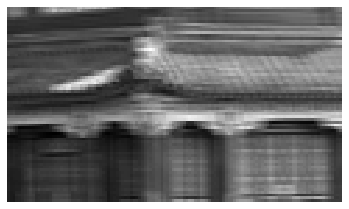

In [9]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

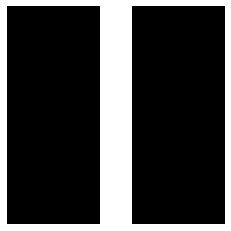

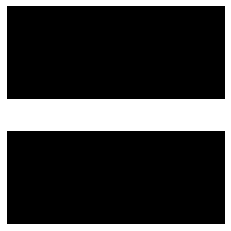

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer in Keras

Using `keras.layers.Conv2D()`:

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

## Padding

There are two padding methods: "VALID" or "SAME":
- If set to "VALID", the convolutional layer does not use zero padding, and may ignore some rows and columns at the bottom and right of the input image, depending on the stride.
- If set to "SAME", the convolutional layer uses zero padding if necessary. In this case, the number of output neurons is equal to the number of input neurons divided by the stride, rounded up. Then zeros are added as evenly as possible around the inputs.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/padding.png" width="70%"></img>

## Pooling layer

The goal of pooling layers is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).

Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean. 



## Max pooling

The following figure shows a sample of the most common pooling layer: Max pooling layer (2 × 2 pooling kernel, stride 2, no padding).

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/max_pooling.png" width="80%"></img>

In [2]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [10]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


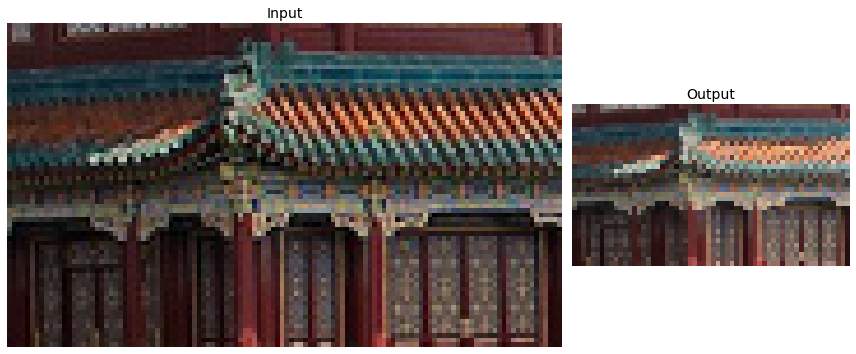

In [11]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

The max pooling reduces the computations, memory usage and the number of parameters.

## Average pooling

- Average pooling works exactly like a max pooling layer, except it computes the mean rather than the max. 
- Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest feature, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. 
- To create an average pooling layer, just use AvgPool2D instead of MaxPool2D.

In [12]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [13]:
output_avg = avg_pool(cropped_images)

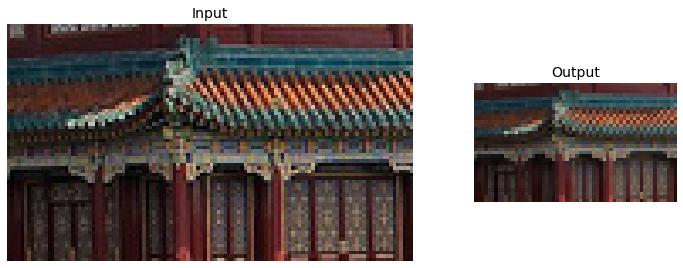

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

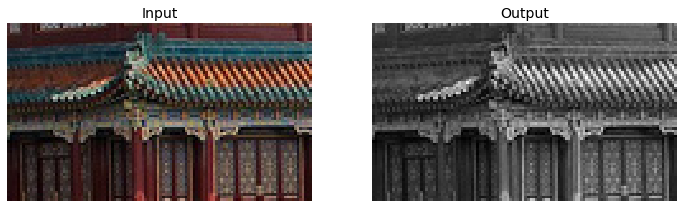

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Depth-wise pooling

Max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions, although this is not as common.

This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern, such as hand-written digits, and the depth-wise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything else: thickness, brightness, skew, color, and so on.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/depth-wise.png" width="70%"></img>

Keras does not include a depth-wise max pooling layer, but TensorFlow’s low-level Deep Learning API does: just use the tf.nn.max_pool() function, and specify the kernel size and strides as 4-tuples. The first three values of each should be 1: this indi‐ cates that the kernel size and stride along the batch, height and width dimensions shoud be 1. The last value should be whatever kernel size and stride you want along the depth dimension, for example 3 (this must be a divisor of the input depth; for example, it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3):

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

## Global Average Pooling

One last type of pooling layer that you will often see in modern architectures is the **global average pooling** layer. 

It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). This means that it just outputs a sin‐ gle number per feature map and per instance. Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer, as we will see later in this chapter. 

To create such a layer, simply use the keras.layers.GlobalAvgPool2D class:

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=151, shape=(2, 3), dtype=float64, numpy=
array([[0.27887768, 0.2250719 , 0.20967274],
       [0.51288515, 0.45951634, 0.33423483]])>

# CNN Architectures


Typical CNN architectures stack the following layers:

- a few convolutional layers (each one generally followed by a ReLU layer),
- then a pooling layer, 
- then another few convolutional layers (+ReLU), 
- then another pooling layer, and so on. 

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper.

At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/cnn_architecture.png" width="90%"></img>

A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5 × 5 kernel, it is generally preferable to stack two layers with 3 × 3 ker‐ nels: it will use less parameters and require less computations, and it will usually perform better. One exception to this recommendation is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has 3 channels in general, it will not be too costly.

## Tackling Fashion MNIST With a CNN

In this section, we will use a CNN architecture to classify fashion MNIST images.

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 18s 9ms/step - loss: 0.7021 - accuracy: 0.7580 - val_loss: 0.3759 - val_accuracy: 0.8636
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4157 - accuracy: 0.8611 - val_loss: 0.3354 - val_accuracy: 0.8764
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3591 - accuracy: 0.8790 - val_loss: 0.2931 - val_accuracy: 0.8906
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3256 - accuracy: 0.8903 - val_loss: 0.2871 - val_accuracy: 0.8924
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3048 - accuracy: 0.8970 - val_loss: 0.3028 - val_accuracy: 0.8952
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2885 - accuracy: 0.9030 - val_loss: 0.2868 - val_accuracy: 0.9014
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2741 - accuracy: 0.9073 - val_loss: 0.2926 - val_ac

## ImageNet CNNs

Over the years, variants of this fundamental architecture have been developed, leading to amazing advances in the field. A good measure of this progress is the error rate in competitions such as the ILSVRC ImageNet challenge. In this competition the top-5 error rate for image classification fell from over 26% to less than 2.3% in just six years. The top-five error rate is the number of test images for which the system’s top 5 predictions did not include the correct answer. The images are large (256 pixels high) and there are 1,000 classes, some of which are really subtle (try distinguishing 120 dog breeds). Looking at the evolution of the winning entries is a good way to under‐ stand how CNNs work.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/imagenet_error.jpeg" width="70%"></img>

The following diagrams compares common ImageNet CNNS for the number of parameters and Top-1 Accuracy.

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/imagenet_cnns.png" width="70%"></img>

### AlexNet

The AlexNet CNN architecture11 won the 2012 ImageNet ILSVRC challenge by a large margin: it achieved 17% top-5 error rate while the second best achieved only 26%! It was developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and Geoffrey Hinton.

The following diagram and table show AlexNet architecture:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/alexnet.png" width="80%"></img>

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/alexnet_table.png" width="60%"></img>

### VGGNet

VGGNet, developed by K. Simonyan and A. Zisserman, has also a very simple and classical architecture. It has different versions. The following diagram shows VGG-16 architecture.



<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/vgg-16.png" width="80%"></img>

### GoogLeNet

The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research and it won the ILSVRC 2014 challenge by pushing the top-5 error rate below 7%. This great performance came in large part from the fact that the network was much deeper than previous CNNs.

This was made possible by sub-networks called **inception** modules,which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

The following figure shows an inception module:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/inception_unit.png" width="70%"></img>

It seems that  1x1 layers cannot capture any features since they look at only one pixel at a time. In fact, these layers serve three purposes:
- First, although they cannot capture spatial patterns, they can capture patterns along the depth dimension.
- Second, they are configured to output fewer feature maps than their inputs, so they serve as bottleneck layers, meaning they reduce dimensionality. This cuts the computational cost and the number of parameters, speeding up training and improving generalization.
- Lastly, each pair of convolutional layers ([1 × 1, 3 × 3] and [1 × 1, 5 × 5]) acts like a single, powerful convolutional layer, capable of capturing more complex pat‐ terns. Indeed, instead of sweeping a simple linear classifier across the image (as a single convolutional layer does), this pair of convolutional layers sweeps a two-layer neural network across the image.

The following figure shows the GoogLeNet architecture:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/googlenet.png" width="60%"></img>

### ResNet

The ILSVRC 2015 challenge was won using a Residual Network (or ResNet), developed by Kaiming He et al., which delivered an astounding top-5 error rate under 3.6%, using an extremely deep CNN composed of 152 layers.

The key to being able to train such a deep network is to use **skip connections** (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

The following diagram shows residual learning:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/residual_learning.png" width="70%"></img>

And, the following diagram shows ResNet architecture:

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/resnet.png" width="70%"></img>

There are different falvours of resNet: ResNet-18, ResNet-34, ResNet-52, ResNet-152.

### Xception

Xception (which stands for Extreme Inception) is another variant of the GoogLeNet architecture. It significantly outperformed Inception-v3 on a huge vision task (350 million images and 17,000 classes). 

### SENet

The winning architecture in the ILSVRC 2017 challenge was the Squeeze-and- Excitation Network (SENet). This architecture extends existing architectures such as inception networks or ResNets, and boosts their performance. This allowed SENet to win the competition with an astonishing 2.25% top-5 error rate!

## Building ResNet-34 in Keras

Most CNN architectures described so far are fairly straightforward to implement (although generally you would load a pretrained network instead, as we will see). To illustrate the process, let’s implement a ResNet-34 from scratch using Keras. First, let’s create a ResidualUnit layer:

In [4]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Next, we can build the ResNet-34 simply using a Sequential model, since it is really just a long sequence of layers (we can treat each residual unit as a single layer now that we have the ResidualUnit class):

In [5]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Models From Keras

In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code, in the keras.applications package. For example:

In [7]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


A ResNet-50 model expects 224 × 224 images (other models may expect other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function to resize the images we loaded earlier:

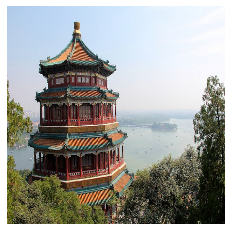

In [9]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

If we don't want to change the aspect ratio, we can resize with pad:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


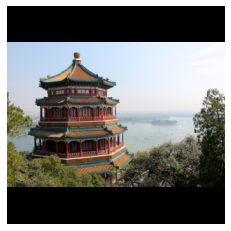

In [10]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

Or, we can try cropping the images to the appropriate aspect ratio before resizing:

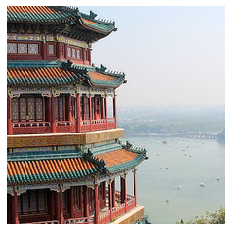

In [11]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

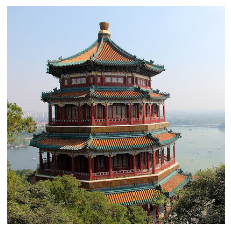

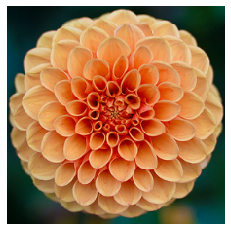

In [12]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or -1 to 1, and so on. Each model provides a preprocess_input() function that you can use to preprocess your images. These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [13]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

Now we can use the pretrained model to make predictions:

In [14]:
Y_proba = model.predict(inputs)
Y_proba.shape

(2, 1000)

In [15]:
Y_proba

array([[7.3548350e-09, 2.1553044e-08, 7.4699020e-09, ..., 1.7062444e-09,
        1.1173285e-07, 3.3828758e-08],
       [2.3477071e-07, 7.0271135e-06, 4.0480032e-07, ..., 5.4022275e-05,
        3.6675756e-05, 1.3372325e-04]], dtype=float32)

If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, you can use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier, its name and the corresponding confidence score:

In [16]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning

If you want to build an image classifier, but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model.

For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets:

In [17]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [20]:
type(info)

tensorflow_datasets.core.dataset_info.DatasetInfo

In [18]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [19]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [21]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [22]:
n_classes = info.features["label"].num_classes

In [23]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [24]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

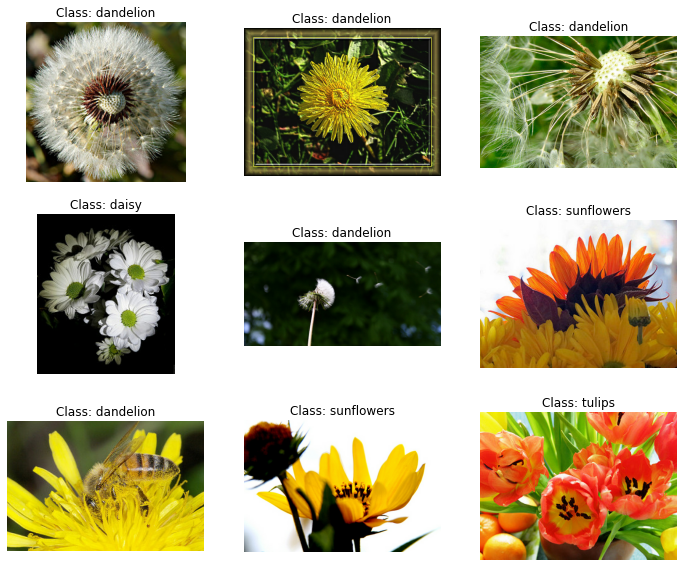

In [25]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Basic preprocessing:

In [26]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [27]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

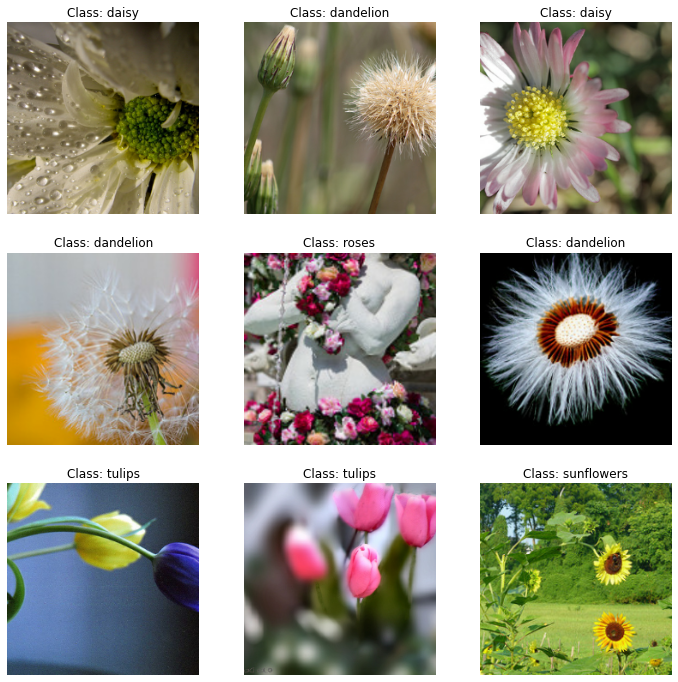

In [28]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

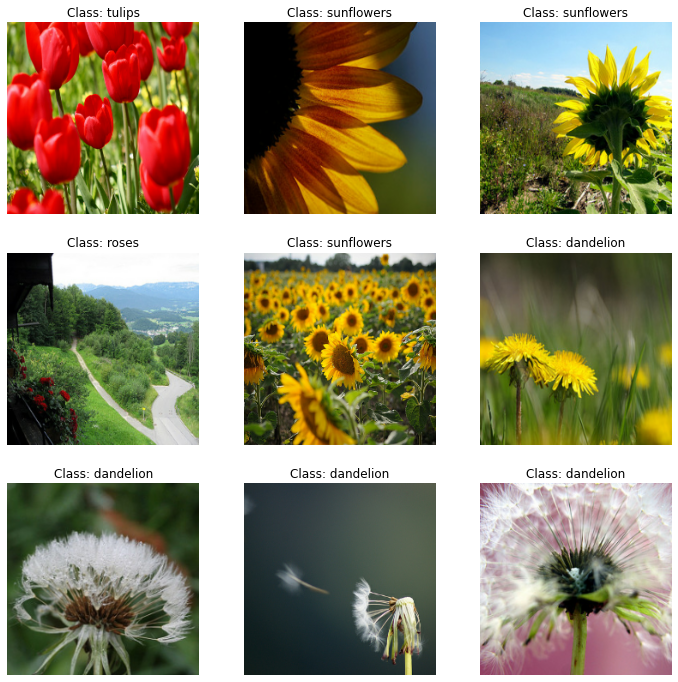

In [29]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network (by setting include_top=False): this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with 1 unit per class, using the softmax activation function. Finally, we create the Keras Model:

In [30]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 0s 0us/step


In [31]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_41
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_42
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_43
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

It’s usually a good idea to freeze the weights of the pre‐ trained layers, at least at the beginning of training (specially, if you don't have a lot of data):

In [32]:
for layer in base_model.layers:
    layer.trainable = False


Finally, we can compile the model and start training:

In [33]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
86/86 [==============================] - 18s 156ms/step - loss: 1.1125 - accuracy: 0.8023 - val_loss: 0.9892 - val_accuracy: 0.8585
Epoch 2/5
86/86 [==============================] - 13s 148ms/step - loss: 0.4690 - accuracy: 0.9062 - val_loss: 0.8790 - val_accuracy: 0.8511
Epoch 3/5
86/86 [==============================] - 13s 150ms/step - loss: 0.2967 - accuracy: 0.9259 - val_loss: 0.7156 - val_accuracy: 0.8805
Epoch 4/5
86/86 [==============================] - 13s 152ms/step - loss: 0.2091 - accuracy: 0.9371 - val_loss: 0.7319 - val_accuracy: 0.8713
Epoch 5/5
86/86 [==============================] - 13s 155ms/step - loss: 0.1659 - accuracy: 0.9484 - val_loss: 0.6637 - val_accuracy: 0.8658


After training the model for a few epochs, its validation accuracy reached to a a high level and stopped making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all layers (or you could try unfreezing just the top ones), and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid dam‐ aging the pretrained weights:

In [34]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 60s 622ms/step - loss: 0.3277 - accuracy: 0.8993 - val_loss: 0.9016 - val_accuracy: 0.8051
Epoch 2/40
86/86 [==============================] - 55s 642ms/step - loss: 0.1164 - accuracy: 0.9600 - val_loss: 0.3339 - val_accuracy: 0.8934
Epoch 3/40
86/86 [==============================] - 56s 655ms/step - loss: 0.0665 - accuracy: 0.9818 - val_loss: 0.2964 - val_accuracy: 0.9081
Epoch 4/40
86/86 [==============================] - 56s 651ms/step - loss: 0.0479 - accuracy: 0.9858 - val_loss: 0.3180 - val_accuracy: 0.9062
Epoch 5/40
86/86 [==============================] - 56s 654ms/step - loss: 0.0391 - accuracy: 0.9862 - val_loss: 0.2452 - val_accuracy: 0.9154
Epoch 6/40
86/86 [==============================] - 58s 671ms/step - loss: 0.0244 - accuracy: 0.9909 - val_loss: 0.3485 - val_accuracy: 0.9173
Epoch 7/40
86/86 [==============================] - 56s 657ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.3130 - val_accuracy: 0.9136